In [3]:
import pandas as pd

In [4]:
movie_plots_data = pd.read_csv('wiki_movie_plots_deduped.csv')

# 2. Topic Modeling

In [5]:
import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.stem.porter import *
import numpy as np
np.random.seed(1234)
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /home/andrei/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

## 2.1. Select data subset: films newer than 2015 and of "comedy" genre

In [7]:
movie_plots_selection = movie_plots_data[(movie_plots_data['Release Year'] >= 2015) & movie_plots_data['Genre'].str.contains('comedy')]

In [8]:
movie_plots = movie_plots_selection.Plot
movie_plots.head()

16917    Jimmy Callahan (Kevin Hart) provides best man ...
16922    Lord Charlie Mortdecai, an unscrupulous art de...
16925    Quinn (Simon Helberg) and Devon (Melanie Lynsk...
16934    Jerry (Ryan Reynolds) is an upbeat man who wor...
16935    The film opens with an unnamed dancer (Charles...
Name: Plot, dtype: object

## 2.2. Preprocess Data

In [9]:
stemmer = SnowballStemmer('english')

def lemmatize_stemming(text):
    # lemmatize + stem a text
    return stemmer.stem(WordNetLemmatizer().lemmatize(text, pos='v'))

def preprocess(text):
    result = []
    for token in gensim.utils.simple_preprocess(text):
        # remove stopword tokens and tokend of length small than 3
        if token not in gensim.parsing.preprocessing.STOPWORDS and len(token) > 2:
            # lemmatize + stem tokens
            result.append(lemmatize_stemming(token))
    return result

In [10]:
# preprocess movie plots
preprocessed_docs = movie_plots.map(preprocess)
preprocessed_docs.head()

16917    [jimmi, callahan, kevin, hart, provid, best, m...
16922    [lord, charli, mortdecai, unscrupul, art, deal...
16925    [quinn, simon, helberg, devon, melani, lynskey...
16934    [jerri, ryan, reynold, upbeat, man, work, bath...
16935    [film, open, unnam, dancer, charl, lil, buck, ...
Name: Plot, dtype: object

In [13]:
# example before preprocessing
print(movie_plots[movie_plots.index[0]][0:118])

Jimmy Callahan (Kevin Hart) provides best man services, through The Best Man Inc., for guys who don't have the friends


In [18]:
# example after preprocessing
preprocessed_docs[preprocessed_docs.index[0]][0:12]

['jimmi',
 'callahan',
 'kevin',
 'hart',
 'provid',
 'best',
 'man',
 'servic',
 'best',
 'man',
 'guy',
 'friend']

## 2.3. Bag of Words

In [20]:
# BoW dictionary on the dataset
dictionary = gensim.corpora.Dictionary(preprocessed_docs)

In [21]:
# filter out extreme values
dictionary.filter_extremes(no_below=10, no_above=0.5, keep_n=100000)

In [23]:
# create corpus using BoW transformation
bow_corpus = [dictionary.doc2bow(doc) for doc in preprocessed_docs]

In [25]:
# count word occurence
word_dict_count = {}
for doc in bow_corpus:
    for i, word_info in enumerate(doc):
        word = dictionary[word_info[0]]
        word_count = word_info[1]
        if word in word_dict_count:
            word_dict_count[word] += word_count
        else:
            word_dict_count[word] = 0

In [26]:
# create word dictionary
word_dict = {'words': list(word_dict_count.keys()), 'count': list(word_dict_count.values())}

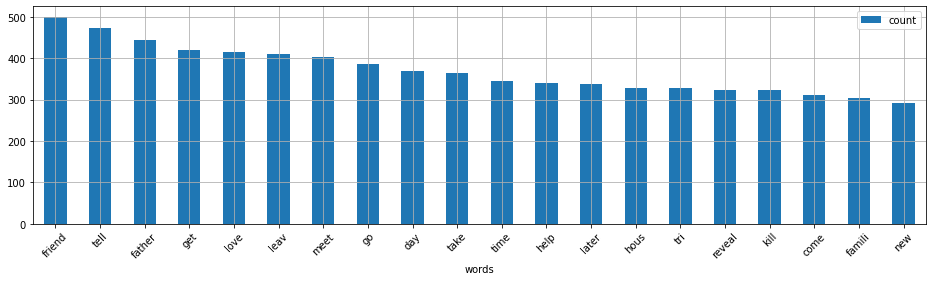

In [27]:
# create DataFrame
word_df = pd.DataFrame.from_dict(word_dict)
word_df.sort_values(by=['count'], ascending=False).head(20).plot(x='words', kind='bar', figsize=(16,4), rot=45, grid=True)

## 2.5. LDA using BoW

In [28]:
# train LDA model using BoW
lda_model = gensim.models.LdaMulticore(bow_corpus, num_topics=4, id2word=dictionary, passes=2, workers=4)

In [29]:
def show_model_topics(model, words_per_topic=10):
    for idx, topic in model.show_topics(num_words=words_per_topic, formatted=False):
        print('Topic {} | Words & Probability: {}'.format(idx, topic))

In [30]:
show_model_topics(lda_model, words_per_topic=5)

Topic 0 | Words & Probability: [('friend', 0.008891518), ('love', 0.008689221), ('school', 0.007159237), ('leav', 0.006992267), ('year', 0.006305754)]
Topic 1 | Words & Probability: [('tell', 0.0089802835), ('get', 0.0077654677), ('leav', 0.0077217277), ('meet', 0.007194425), ('tri', 0.0070262244)]
Topic 2 | Words & Probability: [('father', 0.012084462), ('friend', 0.011638937), ('love', 0.0103906235), ('day', 0.008691751), ('meet', 0.008162173)]
Topic 3 | Words & Probability: [('hous', 0.0087442165), ('kill', 0.0082873795), ('friend', 0.007807175), ('tell', 0.0067682364), ('ghost', 0.006634202)]


## 2.6. LDA using TF-IDF

In [31]:
from gensim import corpora, models

# create corpus
tfidf = models.TfidfModel(bow_corpus)
corpus_tfidf = tfidf[bow_corpus]

In [32]:
# train LDA model using TF-IDF
lda_model_tfidf = gensim.models.LdaMulticore(corpus_tfidf, num_topics=4, id2word=dictionary, passes=2, workers=4)

In [33]:
show_model_topics(lda_model_tfidf, words_per_topic=10)

Topic 0 | Words & Probability: [('jam', 0.0031709876), ('movi', 0.003166763), ('kill', 0.0029561569), ('meet', 0.0028727802), ('krishna', 0.0028228683), ('life', 0.0027685084), ('ami', 0.0027439748), ('wife', 0.0026386296), ('famili', 0.0026143012), ('year', 0.0025583897)]
Topic 1 | Words & Probability: [('love', 0.0036079504), ('man', 0.0035566583), ('film', 0.0035474547), ('girl', 0.0030152993), ('stori', 0.0029316081), ('dream', 0.0028983296), ('comedi', 0.002881044), ('ghost', 0.0027841786), ('friend', 0.002782249), ('villag', 0.002657473)]
Topic 2 | Words & Probability: [('villag', 0.005388834), ('father', 0.0034083622), ('school', 0.0032747984), ('guy', 0.0028580315), ('kill', 0.00283646), ('girl', 0.002750024), ('polic', 0.002740946), ('love', 0.0026647595), ('set', 0.0025071308), ('wed', 0.002482246)]
Topic 3 | Words & Probability: [('ghost', 0.0039045447), ('team', 0.003619682), ('hous', 0.0034885944), ('father', 0.0034885078), ('film', 0.0034292403), ('love', 0.003328964), ('

## 2.7. Testing

### 2.7.1. Random Plot Sample

In [35]:
sample = movie_plots[movie_plots.index[23]]
txt = dictionary.doc2bow(preprocess(sample))

In [36]:
# Classify sample document using LDA BoW model
for index, score in sorted(lda_model[txt], reverse=True):
    print('\nScore: {}\t \nTopic: {}'.format(score, lda_model.print_topic(index, 10)))


Score: 0.3474341332912445	 
Topic: 0.009*"hous" + 0.008*"kill" + 0.008*"friend" + 0.007*"tell" + 0.007*"ghost" + 0.007*"decid" + 0.006*"get" + 0.006*"time" + 0.006*"stori" + 0.006*"famili"

Score: 0.059517405927181244	 
Topic: 0.012*"father" + 0.012*"friend" + 0.010*"love" + 0.009*"day" + 0.008*"meet" + 0.008*"tell" + 0.008*"go" + 0.007*"get" + 0.007*"famili" + 0.006*"reveal"

Score: 0.5621134638786316	 
Topic: 0.009*"tell" + 0.008*"get" + 0.008*"leav" + 0.007*"meet" + 0.007*"tri" + 0.007*"take" + 0.007*"help" + 0.007*"go" + 0.006*"return" + 0.006*"school"

Score: 0.030934959650039673	 
Topic: 0.009*"friend" + 0.009*"love" + 0.007*"school" + 0.007*"leav" + 0.006*"year" + 0.006*"return" + 0.006*"tell" + 0.006*"new" + 0.006*"home" + 0.006*"take"


In [37]:
# Classify sample document using LDA TF-IDF model
for index, score in sorted(lda_model_tfidf[txt], reverse=True):
    print('\nScore: {}\t \nTopic: {}'.format(score, lda_model_tfidf.print_topic(index, 10)))


Score: 0.8504701256752014	 
Topic: 0.005*"villag" + 0.003*"father" + 0.003*"school" + 0.003*"guy" + 0.003*"kill" + 0.003*"girl" + 0.003*"polic" + 0.003*"love" + 0.003*"set" + 0.002*"wed"

Score: 0.14543181657791138	 
Topic: 0.003*"jam" + 0.003*"movi" + 0.003*"kill" + 0.003*"meet" + 0.003*"krishna" + 0.003*"life" + 0.003*"ami" + 0.003*"wife" + 0.003*"famili" + 0.003*"year"


### 2.7.2. Unseen Document

In [38]:
# define unseen text
unseen_document = 'The main character runs out of the house and tells his friend to get some help from someone in front of the school.'

In [39]:
bow_vector = dictionary.doc2bow(preprocess(unseen_document))

for index, score in sorted(lda_model[bow_vector], key=lambda tup: tup[1], reverse=True):
    print('Score: {}\t Topic: {}'.format(score, lda_model.print_topic(index, 10)))

Score: 0.9094007611274719	 Topic: 0.009*"tell" + 0.008*"get" + 0.008*"leav" + 0.007*"meet" + 0.007*"tri" + 0.007*"take" + 0.007*"help" + 0.007*"go" + 0.006*"return" + 0.006*"school"
Score: 0.030334224924445152	 Topic: 0.009*"hous" + 0.008*"kill" + 0.008*"friend" + 0.007*"tell" + 0.007*"ghost" + 0.007*"decid" + 0.006*"get" + 0.006*"time" + 0.006*"stori" + 0.006*"famili"
Score: 0.03016793355345726	 Topic: 0.012*"father" + 0.012*"friend" + 0.010*"love" + 0.009*"day" + 0.008*"meet" + 0.008*"tell" + 0.008*"go" + 0.007*"get" + 0.007*"famili" + 0.006*"reveal"
Score: 0.030097046867012978	 Topic: 0.009*"friend" + 0.009*"love" + 0.007*"school" + 0.007*"leav" + 0.006*"year" + 0.006*"return" + 0.006*"tell" + 0.006*"new" + 0.006*"home" + 0.006*"take"


In [40]:
# LDA TF-IDF
for index, score in sorted(lda_model_tfidf[bow_vector], key=lambda tup: tup[1], reverse=True):
    print("Score: {}\t Topic: {}".format(score, lda_model_tfidf.print_topic(index, 10)))

Score: 0.9108977317810059	 Topic: 0.004*"ghost" + 0.004*"team" + 0.003*"hous" + 0.003*"father" + 0.003*"film" + 0.003*"love" + 0.003*"babi" + 0.003*"wed" + 0.003*"marri" + 0.003*"win"
Score: 0.029825083911418915	 Topic: 0.005*"villag" + 0.003*"father" + 0.003*"school" + 0.003*"guy" + 0.003*"kill" + 0.003*"girl" + 0.003*"polic" + 0.003*"love" + 0.003*"set" + 0.002*"wed"
Score: 0.029706696048378944	 Topic: 0.003*"jam" + 0.003*"movi" + 0.003*"kill" + 0.003*"meet" + 0.003*"krishna" + 0.003*"life" + 0.003*"ami" + 0.003*"wife" + 0.003*"famili" + 0.003*"year"
Score: 0.029570473358035088	 Topic: 0.004*"love" + 0.004*"man" + 0.004*"film" + 0.003*"girl" + 0.003*"stori" + 0.003*"dream" + 0.003*"comedi" + 0.003*"ghost" + 0.003*"friend" + 0.003*"villag"


## 2.8. Visualization

### 2.8.1. LDA Model

In [41]:
import pyLDAvis.gensim

In [43]:
lda_display = pyLDAvis.gensim.prepare(lda_model, bow_corpus, dictionary, sort_topics=False)
pyLDAvis.display(lda_display)

### 2.8.2. LDA TF-IDF Model

In [44]:
lda_tfidf_display = pyLDAvis.gensim.prepare(lda_model_tfidf, bow_corpus, dictionary, sort_topics=False)

In [45]:
pyLDAvis.display(lda_tfidf_display)